<a href="https://colab.research.google.com/github/alexkupin/EMG_Gesture_Detection_Using_MultiTasked_Learning/blob/main/GestureEMGAdaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#########
#1)
!git clone https://github.com/alexkupin/EMG_Gesture_Detection_Using_MultiTasked_Learning


Cloning into 'EMG_Gesture_Detection_Using_MultiTasked_Learning'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 115 (delta 1), reused 114 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 16.86 MiB | 4.24 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (74/74), done.


In [2]:
!pip install pandas
!pip install sklearn
!pip install pyemgpipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=5dd75c34814d7947077b07f645f6097ac41d13645995af2b79e8a1146d993bcd
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 2.7 MB/s 


In [40]:
import pandas
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from matplotlib.figure import SubplotParams
import matplotlib.pyplot as plot
import pyemgpipeline as pep
import math
from scipy import signal
import itertools
import operator

#Function derives the RMS given a window of time
def rms(window):
  sumXSqared=0
  for x in window:
    sumXSqared+=x*x
  return math.sqrt(sumXSqared/len(window))



def most_common(L):
  # get an iterable of (item, iterable) pairs
  SL = sorted((x, i) for i, x in enumerate(L))
  # print 'SL:', SL
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    # print 'item %r, count %r, minind %r' % (item, count, min_index)
    return count, -min_index
  # pick the highest-count/earliest item
  return max(groups, key=_auxfun)[0]

def getMeanAbsoluteValue(window):
  #Get the absolute Value of mean
  sumX=0
  for x in window:
    sumX+=x
  mean = sumX/len(window)
  sumX=0 
  for index in window:
    sumX+=index-mean
  return sumX/len(window)

#function gets the slope sign change given a window
def getSlopeSign(window):
  m=np.diff(window)
  sumX = 0
  for x in m:
    sumX+=x
  mean = sumX/len(m)
  return (int)(0>=(sumX/len(m)))

#function gets the willison Amplitude given a threshold value and a window of time
def getWillisonAmp(window, threshold):
  count = 0
  for x in window:
    if x>threshold:
      count+=1
  return count


  
##############################################################################################################################
##############################################################################################################################
#begin data processing
df = pandas.DataFrame()
li=[]
#iterate through folders
for x in range(1,37):
  if(x<10):
    pathf = '/content/EMG_Gesture_Detection_Using_MultiTasked_Learning/EMG_data_for_gestures-master/0' + str(x)  

  else:
    pathf = '/content/EMG_Gesture_Detection_Using_MultiTasked_Learning/EMG_data_for_gestures-master/' + str(x)

  for filename in os.listdir(pathf):
    f = os.path.join(pathf, filename)
    # checking if it is a file
    if os.path.isfile(f):
       li.append(pandas.read_csv(f,delim_whitespace=True))


In [4]:
#EMG plotting parameters to view plots
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=8,
    fig_kwargs={
        'figsize': (8, 6),
        'dpi': 80,
        'subplotpars': SubplotParams(wspace=0, hspace=0.6),
    },
    line2d_kwargs={
        'color': 'red',
    }
)

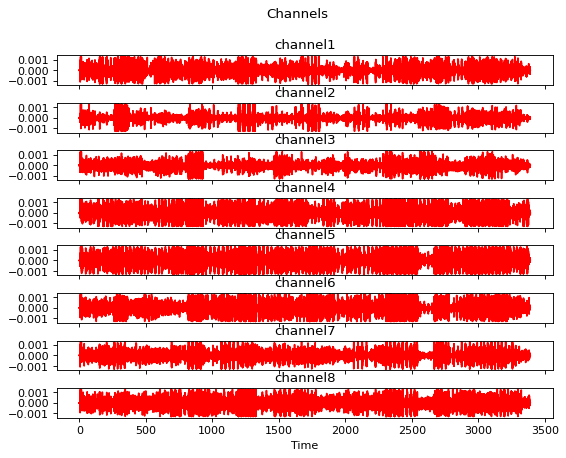

In [5]:
       
df = pandas.concat(li,ignore_index=True)
dataArr=df.to_numpy()
#choosing a train test split of 80-10-10 because it is a smaller dataset so it needs a larger amount to train on.
[train,test]=train_test_split(dataArr, test_size = 0.2, shuffle = False)
#Setting Up SKlearn Kfold Cross validation
crossValidation = KFold(n_splits=10, random_state=1, shuffle=True)

#split up labels and training
X = train[:,1:9]
Y = train[:,9]

sample_rate = 1000
channel_names=["channel1","channel2","channel3","channel4","channel5","channel6","channel7","channel8"]

m = pep.wrappers.EMGMeasurement(X, hz=1000, trial_name="Channels",
                                channel_names=channel_names, emg_plot_params=emg_plot_params)
m.plot()

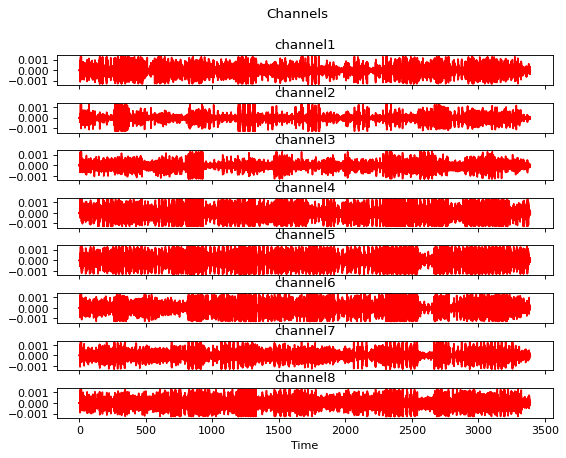

In [6]:
#apply DC offset remover
m.apply_dc_offset_remover()
m.plot()

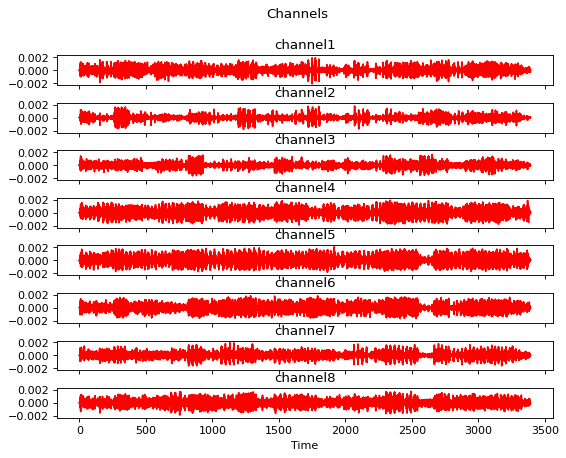

In [7]:
#apply Bandpass filter
m.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
m.plot()

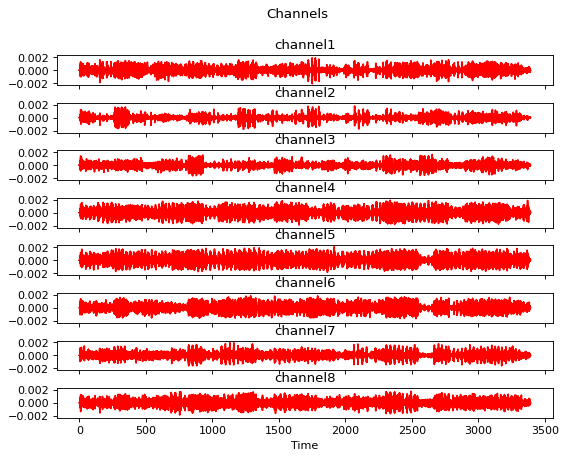

In [8]:
#Get Lowest RMS for each channel
lowestRMS=np.ones(8)
prevTime=-1.0

for channel in range(0,8):
  for index in range(10,len(X),10):
    if(index+10>=len(m.data)):
      break
    else:
       rmsCurr = rms(m.data[index-10:index+10,channel])
       if(rmsCurr<lowestRMS[channel]):
         lowestRMS[channel] = rmsCurr

  #applies the lowest RMS  threshold to the raw data channel to cut out baseline noise.
  m.data[:,channel] = m.data[:,channel] - np.full(np.shape(m.data[:,channel]),lowestRMS[channel])
m.plot()

In [27]:
#bins the X data to respected overlapped windows
#bins the Y data to the overlapped windows
newXData = list()
newYData = list()
for index in range(125,len(X),125):
      if(index+124>=len(m.data)):
        break
      newXData.append(m.data[index-125:index+125,channel])
      #gets the most common Y value and uses that for the label
      newYData.append(most_common(Y[index-125:index+125]))

      
      

In [42]:

newRMSData= np.zeros((len(newXData),8))
meanAbsoluteValue= np.zeros((len(newXData),8))
slopeSignChange = np.zeros((len(newXData),8))
willisonAmplitude = np.zeros((len(newXData),8))
variance = np.zeros((len(newXData),8))
prevTime=-1.0;
for channel in range(0,8):
  count=0
  for index in range(125,len(X),125):
    if(index+124>=len(m.data)):
      break
    else:
      newRMSData[count,channel] = (rms(m.data[index-125:index+125,channel]))
      meanAbsoluteValue[count,channel] = (getMeanAbsoluteValue(m.data[index-125:index+125,channel]))
      slopeSignChange[count,channel] = (getSlopeSign(m.data[index-125:index+125,channel]))
      willisonAmplitude[count,channel] = (getWillisonAmp(m.data[index-125:index+125,channel],1e-5))
      variance[count,channel] = np.var(m.data[index-125:index+125,channel])
    count+=1

      


In [43]:
processedData = pandas.DataFrame(meanAbsoluteValue, columns =["MAVchannel1","MAVchannel2","MAVchannel3","MAVchannel4","MAVchannel5","MAVchannel6","MAVchannel7","channel8"])

In [44]:
for channel in range(0,8): 
  processedData["RMS" + str(channel+1)] = newRMSData[:,channel]
  processedData["Var" + str(channel+1)] = variance[:,channel]
  processedData["WA" + str(channel+1)] = willisonAmplitude[:,channel]
  processedData["SSC" + str(channel+1)] = slopeSignChange[:,channel]


In [47]:
model = AdaBoostClassifier(base_estimator=GradientBoostingClassifier(random_state=0),learning_rate=0.01)
model.fit(processedData.to_numpy(),newYData)

AdaBoostClassifier(base_estimator=GradientBoostingClassifier(random_state=0),
                   learning_rate=0.01)

In [51]:
#bins the X Test data to respected overlapped windows
#bins the Y Test data to the overlapped windows
X_Test = test[:,1:9]
Y_Test = test[:,9]


sample_rate = 1000
channel_names=["channel1","channel2","channel3","channel4","channel5","channel6","channel7","channel8"]

m_test = pep.wrappers.EMGMeasurement(X_Test, hz=1000, trial_name="Channels",
                                channel_names=channel_names, emg_plot_params=emg_plot_params)
#apply DC offset remover
m_test.apply_dc_offset_remover()
m_test.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
#Get Lowest RMS for each channel
lowestRMS=np.ones(8)
prevTime=-1.0

for channel in range(0,8):
  for index in range(10,len(X),10):
    if(index+10>=len(m_test.data)):
      break
    else:
       rmsCurr = rms(m_test.data[index-10:index+10,channel])
       if(rmsCurr<lowestRMS[channel]):
         lowestRMS[channel] = rmsCurr

  #applies the lowest RMS  threshold to the raw data channel to cut out baseline noise.
  m_test.data[:,channel] = m_test.data[:,channel] - np.full(np.shape(m_test.data[:,channel]),lowestRMS[channel])

newXTestData = list()
newYTestData = list()
for index in range(125,len(X_Test),125):
      if(index+124>=len(m_test.data)):
        break
      newXTestData.append(m_test.data[index-125:index+125,channel])
      #gets the most common Y value and uses that for the label
      newYTestData.append(most_common(Y_Test[index-125:index+125]))

  
newRMSData= np.zeros((len(newXTestData),8))
meanAbsoluteValue= np.zeros((len(newXTestData),8))
slopeSignChange = np.zeros((len(newXTestData),8))
willisonAmplitude = np.zeros((len(newXTestData),8))
variance = np.zeros((len(newXTestData),8))
prevTime=-1.0;
for channel in range(0,8):
  count=0
  for index in range(125,len(X_Test),125):
    if(index+124>=len(m_test.data)):
      break
    else:
      newRMSData[count,channel] = (rms(m_test.data[index-125:index+125,channel]))
      meanAbsoluteValue[count,channel] = (getMeanAbsoluteValue(m_test.data[index-125:index+125,channel]))
      slopeSignChange[count,channel] = (getSlopeSign(m_test.data[index-125:index+125,channel]))
      willisonAmplitude[count,channel] = (getWillisonAmp(m_test.data[index-125:index+125,channel],1e-5))
      variance[count,channel] = np.var(m_test.data[index-125:index+125,channel])
    count+=1

  processedData_test = pandas.DataFrame(meanAbsoluteValue, columns =["MAVchannel1","MAVchannel2","MAVchannel3","MAVchannel4","MAVchannel5","MAVchannel6","MAVchannel7","channel8"])    
  for channel in range(0,8): 
    processedData_test["RMS" + str(channel+1)] = newRMSData[:,channel]
    processedData_test["Var" + str(channel+1)] = variance[:,channel]
    processedData_test["WA" + str(channel+1)] = willisonAmplitude[:,channel]
    processedData_test["SSC" + str(channel+1)] = slopeSignChange[:,channel]



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


0.6537837439150317

In [52]:
model.score(processedData_test.to_numpy(),newYTestData)

0.6537837439150317